In [16]:
import torch
from sagemakercv.detection.detector import build_detection_model
from utils import (unarchive_data, 
                   get_training_world, 
                   is_sm, 
                   is_sm_dist, 
                   get_herring_world,
                   config_check)
from sagemakercv.training import make_optimizer, make_lr_scheduler
from sagemakercv.data import make_data_loader
from sagemakercv.data.utils import prefetcher
from sagemakercv.utils.checkpoint import DetectronCheckpointer
from sagemakercv.utils.runner import build_hooks, Runner
from sagemakercv.utils.runner.hooks.checkpoint import DetectronCheckpointHook
from sagemakercv.training.trainers import train_step
import apex
from configs import cfg
from tqdm.auto import tqdm
from statistics import mean
from sagemakercv.detection.backbone.darknet import build_darknet_backbone
from sagemakercv.detection.dense_heads.yolo_head import build_yolo_head
from sagemakercv.detection.detector.yolo_detector import Yolov3Detector
from sagemakercv import _C as C

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

if (torch._C, '_jit_set_profiling_executor') :
    torch._C._jit_set_profiling_executor(False)
if (torch._C, '_jit_set_profiling_mode') :
    torch._C._jit_set_profiling_mode(False)
    

In [2]:
cfg.merge_from_file('configs/st_yolo.yaml')

In [3]:
#config_check(cfg)
#cfg.freeze()
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.0002

In [4]:
train_coco_loader, num_iterations = make_data_loader(cfg)

NOTE! Installing ujson may make loading annotations faster.
loading annotations into memory...
Done (t=17.87s)
creating index...
index created!


In [5]:
device = torch.device(cfg.MODEL.DEVICE)
train_iterator = prefetcher(iter(train_coco_loader), device)

[2021-08-23 20:54:02.432 ip-172-31-0-120:96034 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-23 20:54:02.480 ip-172-31-0-120:96034 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [6]:
model = build_detection_model(cfg)
model.to(device)
optimizer = make_optimizer(cfg, model)
scheduler = make_lr_scheduler(cfg, optimizer)

/opt/conda/lib/python3.6/site-packages/torch/jit/_recursive.py:202: UserWarning: 'downsample' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))


In [7]:
backbone = build_darknet_backbone(cfg)

In [8]:
state_dict = torch.load('/workspace/data/model_output/epoch_109.ph')
state_dict = {key.replace('module.backbone.', ''): val for key, val in state_dict.items() if '.fc.' not in key}
state_dict = {key.replace('1.weight', 'bn.weight'): val for key, val in state_dict.items()}
state_dict = {key.replace('1.running_mean', 'bn.running_mean'): val for key, val in state_dict.items()}
state_dict = {key.replace('1.bias', 'bn.bias'): val for key, val in state_dict.items()}
state_dict = {key.replace('1.running_var', 'bn.running_var'): val for key, val in state_dict.items()}
state_dict = {key.replace('1.num_batches_tracked', 'bn.num_batches_tracked'): val for key, val in state_dict.items()}
state_dict = {key.replace('0.weight', 'conv.weight'): val for key, val in state_dict.items()}

In [9]:
backbone.backbone.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
head = build_yolo_head(cfg)
model = Yolov3Detector(backbone, head, cfg)
_ = model.to(device)

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.SOLVER.BASE_LR, weight_decay=cfg.SOLVER.WEIGHT_DECAY)
scheduler = make_lr_scheduler(cfg, optimizer)

# model = DDP(model, delay_allreduce=True)

model, optimizer = apex.amp.initialize(model, optimizer, opt_level="O1")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [18]:
def train_step(images, targets, model, optimizer, scheduler, device, dtype, grad_clip=0.0):
    optimizer.zero_grad()
    losses, parsed_targets, feature_maps = model(images, targets)
    with apex.amp.scale_loss(losses['total_loss'], optimizer) as scaled_loss:
        scaled_loss.backward()
    if grad_clip>0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    scheduler.step()
    return losses

In [39]:
loss_history = []
pbar = tqdm(range(5000))
for i in pbar:
    images, targets = next(train_iterator)
    loss = train_step(images, targets, model, optimizer, scheduler, device, None, grad_clip=0.0)
    loss_history.append(float(loss['total_loss']))
    pbar.set_description("Loss: {0:.4f}".format(mean(loss_history[-20:])))

Loss: 0.6167:   1%|          | 51/5000 [00:11<18:46,  4.39it/s]


RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 15.78 GiB total capacity; 14.11 GiB already allocated; 9.75 MiB free; 14.57 GiB reserved in total by PyTorch)

In [24]:
predictions = model(images)

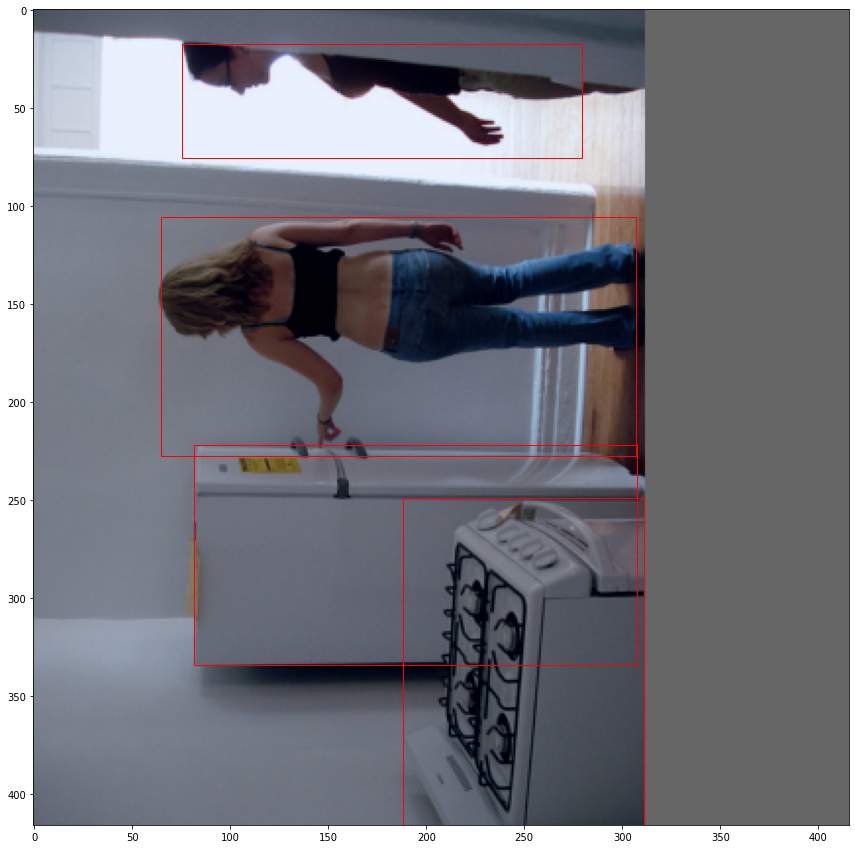

In [36]:
image = 2
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(images.tensors[image].transpose(0, -1).to('cpu').flip(2)/255.+.4)
for box in targets[image].bbox:
    rect = patches.Rectangle((box[1], box[0]), box[3]-box[1], box[2]-box[0], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

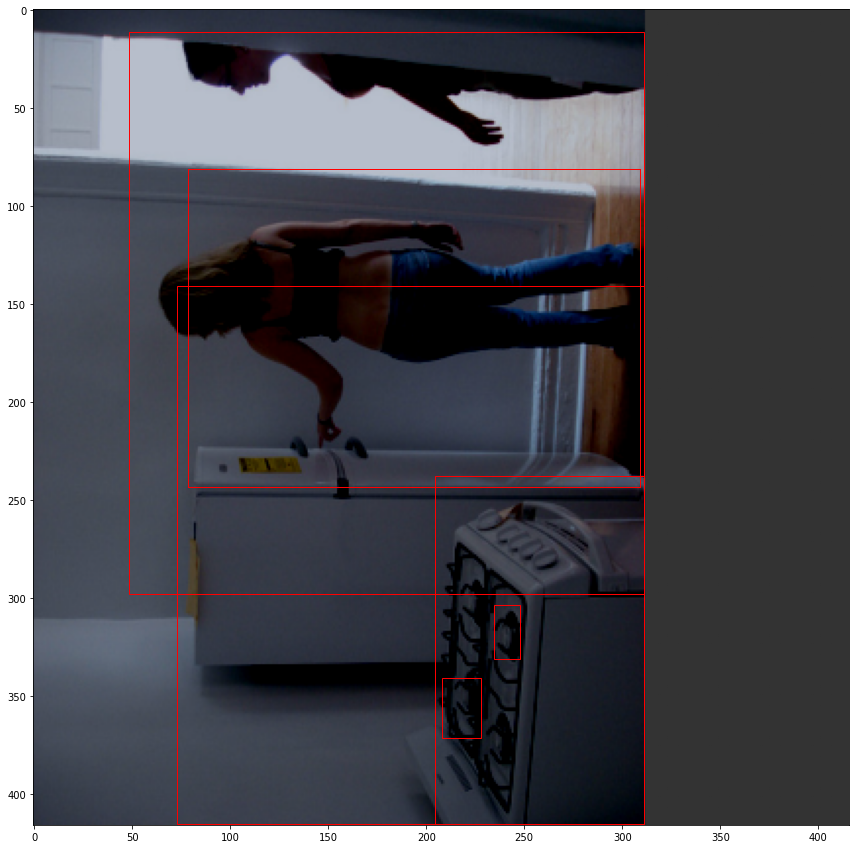

In [37]:
threshold = 0.1
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(images.tensors[image].transpose(0, -1).to('cpu').flip(2)/255.+.2)
for box in predictions[image].bbox[torch.where(predictions[image].extra_fields['scores']>threshold)]:
    rect = patches.Rectangle((box[1], box[0]), box[3]-box[1], box[2]-box[0], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [38]:
predictions[image].extra_fields['labels']

tensor([ 1,  1,  1,  1,  1,  1,  1,  1, 16, 18, 19, 19, 19, 21, 21, 22, 22, 38,
        38, 40, 40, 40, 44, 44, 52, 55, 55, 55, 55, 55, 55, 55, 56, 58, 58, 59,
        59, 68, 70], device='cuda:0')

In [17]:
runner.run(train_iterator, num_iterations)

Start running, work_dir: /root/model_outputs


INFO:sagemakercv.utils.runner.runner:Start running, work_dir: /root/model_outputs


max: 5 epochs


INFO:sagemakercv.utils.runner.runner:max: 5 epochs
INFO:sagemakercv.utils.checkpoint:Loading checkpoint from /home/sagemaker-user/data/coco/weights/pytorch/R-50.pkl


FileNotFoundError: [Errno 2] No such file or directory: '/home/sagemaker-user/data/coco/weights/pytorch/R-50.pkl'

In [12]:
runner.device

device(type='cuda')

In [24]:
[i.dtype for i in runner.optimizer.optimizer.param_groups[1]['params']]

[torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16]

In [210]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
import colorsys
import random

def evaluate(images, model):
    model.eval()
    results_dict = {}
    images = images.to(device)
    cpu_device = torch.device("cpu")
    with torch.no_grad():
        output = model(images)
        output = [o.to(cpu_device) for o in output]
    model.train()
    return output

def random_colors(N, bright=True):
    '''
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    '''
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def restore_image(image, 
                  cfg):
    image = image.to(torch.device("cpu"))
    image = (torch.transpose(image, 0, -1) + torch.tensor(cfg.INPUT.PIXEL_MEAN))/255.
    image = np.flip(np.array(image), 2)
    return image

def add_boxes(boxlist, ax, threshold=0.75):
    for box, score in zip(boxlist.bbox, boxlist.extra_fields['scores']):
        y1, x1, y2, x2 = box
        y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed", edgecolor='r',
                              facecolor='none')
        if score>threshold:
            ax.add_patch(p)

def build_image(image, boxlist, cfg, figsize=(10, 10)):
    image = restore_image(image, cfg)
    fig, ax = plt.subplots(1, figsize=figsize)
    plt.imshow(image)
    add_boxes(boxlist, ax)
    

In [157]:
images, targets = next(eval_coco_iterator)

In [158]:
output = evaluate(images, model)

In [184]:
image = restore_image(images.tensors[2], cfg)

In [175]:
output[2].bbox.shape[0]

83

Adding patch Rectangle(xy=(299, 794), width=268, height=77, angle=0)
Adding patch Rectangle(xy=(435, 550), width=156, height=109, angle=0)
Adding patch Rectangle(xy=(396, 717), width=209, height=75, angle=0)
Adding patch Rectangle(xy=(313, 5), width=205, height=295, angle=0)


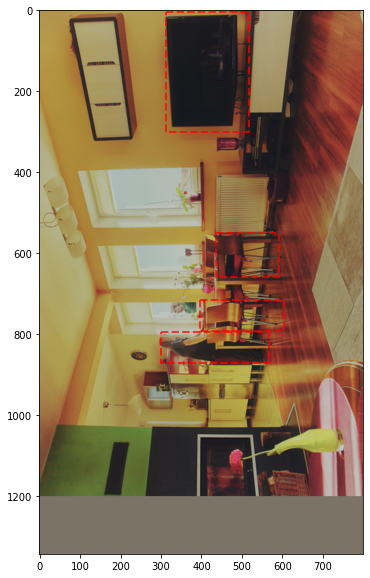

In [200]:
build_image(images.tensors[0], output[0], cfg)

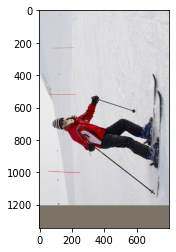

In [185]:
plt.imshow(image)

In [186]:
image

array([[[0.7961635 , 0.80787843, 0.8352161 ],
        [0.7961635 , 0.80787843, 0.8352161 ],
        [0.7961635 , 0.80787843, 0.8352161 ],
        ...,
        [0.8589086 , 0.8588588 , 0.8705102 ],
        [0.854987  , 0.8510157 , 0.8705102 ],
        [0.85106546, 0.8470941 , 0.8705102 ]],

       [[0.7961635 , 0.80787843, 0.8352161 ],
        [0.7961635 , 0.80787843, 0.8352161 ],
        [0.7961635 , 0.80787843, 0.8352161 ],
        ...,
        [0.8589086 , 0.8588588 , 0.8705102 ],
        [0.85106546, 0.8470941 , 0.86658865],
        [0.8471439 , 0.84317255, 0.86658865]],

       [[0.7961635 , 0.80787843, 0.8352161 ],
        [0.7961635 , 0.80787843, 0.8352161 ],
        [0.80008507, 0.8118    , 0.8391377 ],
        ...,
        [0.854987  , 0.85493726, 0.8626671 ],
        [0.8432223 , 0.84317255, 0.8587455 ],
        [0.83930075, 0.8353294 , 0.85482395]],

       ...,

       [[0.48145765, 0.45469216, 0.40384355],
        [0.48145765, 0.45469216, 0.40384355],
        [0.48145765, 0